In [17]:
import sys
from utils import get_intervals
sys.path.append('../')
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from numba import njit  # numba requires numpy <= 2.0 

In [22]:
# experiment setup: for a decreasing success probability pi, subsample the number of counts from two Binomial distribution, Bin(X, pi) and Bin(Y, pi), where X and Y are the control and treatment groups' counts. The LFC should (in expectation) be the same but we observe increasingly sparse data. For each pi, we average the LFC estimates over 1000 runs    

# we will consider a range of pi values
pi_range = np.arange(1, 10)[::-1] * 0.1
 
n_cells = 20
n_runs = 10  # number of times we average the LFC estimates for every pi

data_folder = f"data_from_NB_parameters_r2_100_p_06/n_{n_cells}"
X = pd.read_csv(data_folder + "/control_counts.csv", index_col=0).to_numpy()
Y = pd.read_csv(data_folder + "/treatment_counts.csv", index_col=0).to_numpy()
lfcs = pd.read_csv(data_folder + "/lfcs.csv", index_col=0).to_numpy().reshape(-1)

n_genes = X.shape[-1]
idx = np.argsort(lfcs)  # used for plotting

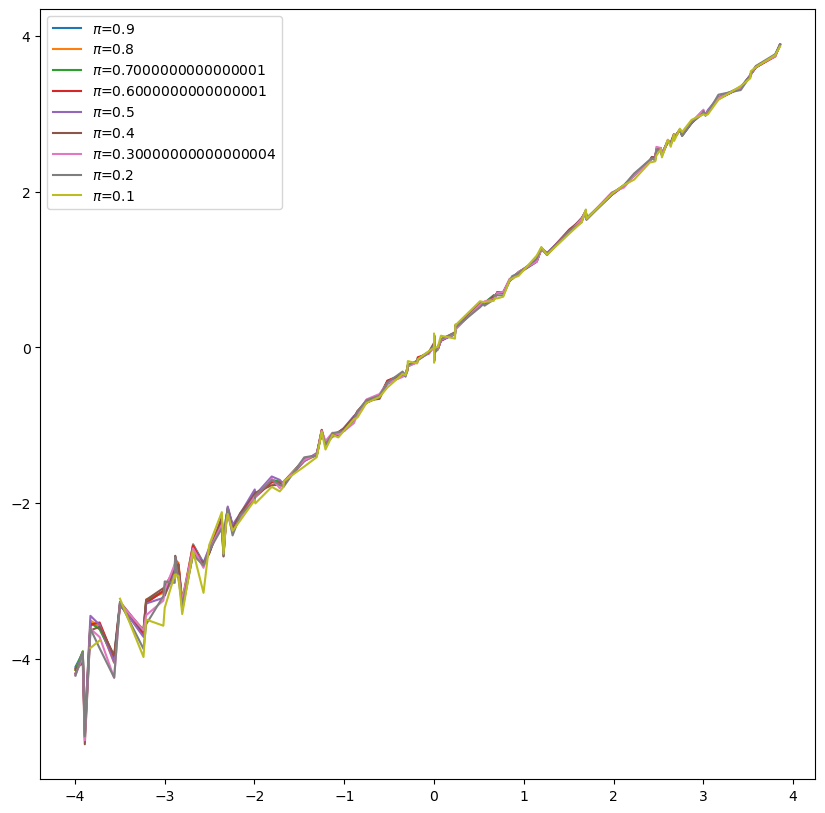

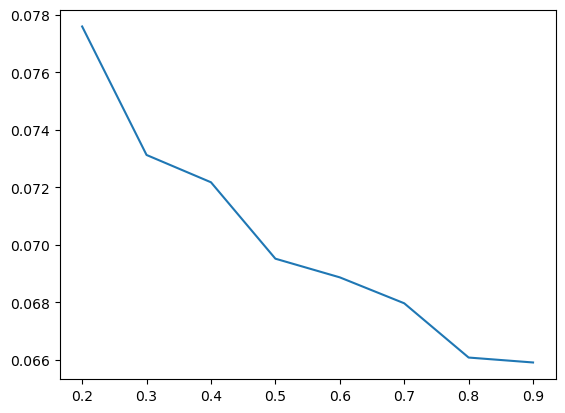

In [26]:
def main(X, Y, pi_range, n_runs, n_genes):
    plt.figure(figsize=(10, 10))
    estimated_lfcs = np.zeros((len(pi_range), n_genes))
    for k, pi in enumerate(pi_range):
        for g in range(n_genes):            
            estimated_lfcs_g = []  # store every LFC estimate in each run
            for i in range(n_runs):
                x = np.random.binomial(X[:, g].astype(np.int64), pi)
                y = np.random.binomial(Y[:, g].astype(np.int64), pi)
                
                x_N_plus = np.sum(x > 0, axis=0)
                x_N_0 = np.sum(x == 0, axis=0)
                log_x = np.log(x[x>0])
                _, log_mu_x, _ = get_intervals(log_x, x_N_plus, x_N_0, eps=1e-3)
                
                
                y_N_plus = np.sum(y > 0, axis=0)
                y_N_0 = np.sum(y == 0, axis=0)
                log_y = np.log(y[y>0])
                _, log_mu_y, _ = get_intervals(log_y, y_N_plus, y_N_0, eps=1e-3)
                
                estimated_lfc = log_mu_y - log_mu_x
                estimated_lfcs_g.append(estimated_lfc)
            
            estimated_lfcs[k, g] = np.mean(estimated_lfcs_g)
    return estimated_lfcs

estimated_lfcs = main(X, Y, pi_range, n_runs, n_genes)
for k, pi in enumerate(pi_range):
    plt.plot(lfcs[idx], estimated_lfcs[k][idx], label=f'$\pi$={pi}')
plt.legend(loc='upper left')
plt.show()

rmses = []
for k, pi in enumerate(pi_range):
    rmse = np.sqrt(np.mean((lfcs - estimated_lfcs[k])**2))
    rmses.append(rmse)
plt.plot(pi_range, rmses)
plt.show()

